In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GoogleStock Price Updated.csv to GoogleStock Price Updated.csv


In [ ]:
# Load the dataset
stock_data = pd.read_csv('GoogleStock Price Updated.csv')

In [ ]:
#Overview of the Data
print(stock_data.head())
print(stock_data.describe())
print(stock_data.info())

# Check for missing values
print(stock_data.isnull().sum())

   Unnamed: 0        Date       Open       High        Low      Close  \
0           0  2013/01/02  18.003504  18.193193  17.931683  18.099348   
1           1  2013/01/03  18.141392  18.316566  18.036036  18.109859   
2           2  2013/01/04  18.251753  18.555305  18.210211  18.467718   
3           3  2013/01/07  18.404655  18.503002  18.282784  18.387136   
4           4  2013/01/08  18.406906  18.425926  18.128880  18.350851   

   Adj Close     Volume  
0  18.099348  101550348  
1  18.109859   92635272  
2  18.467718  110429460  
3  18.387136   66161772  
4  18.350851   66976956  
        Unnamed: 0         Open         High          Low        Close  \
count  2536.000000  2536.000000  2536.000000  2536.000000  2536.000000   
mean   1267.500000    59.746815    60.350351    59.126071    59.752340   
std     732.224465    34.629696    35.037901    34.204419    34.622387   
min       0.000000    17.634134    17.651152    17.405405    17.589338   
25%     633.750000    30.427364    

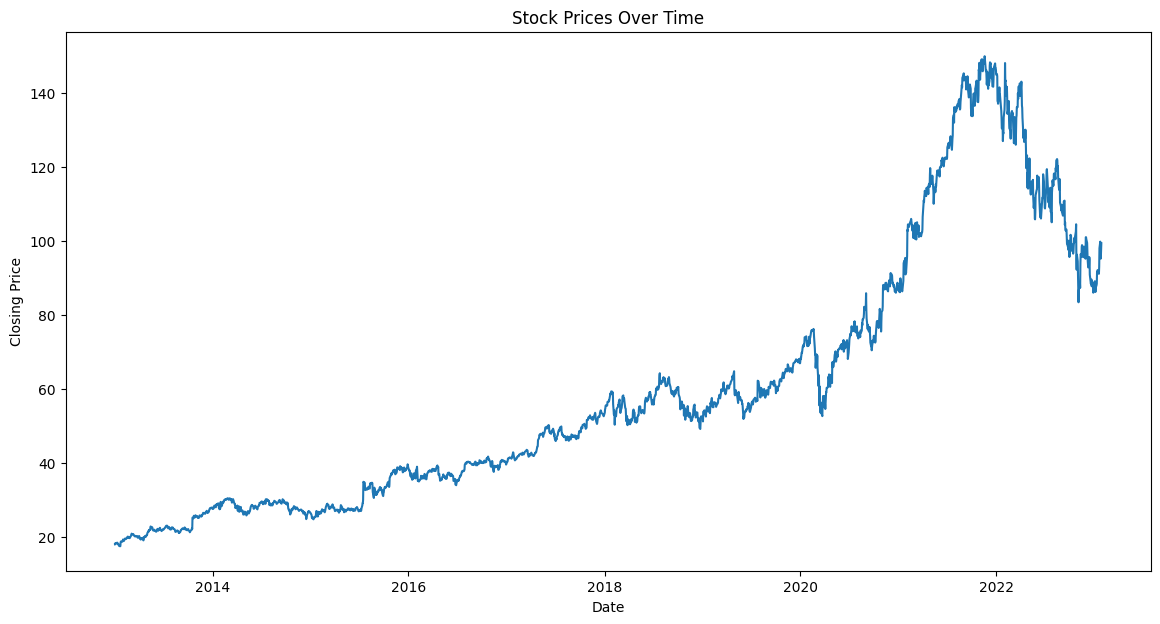

In [ ]:
# Convert the 'Date' column to datetime format and set it as the index
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

# Plot the closing prices over time
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

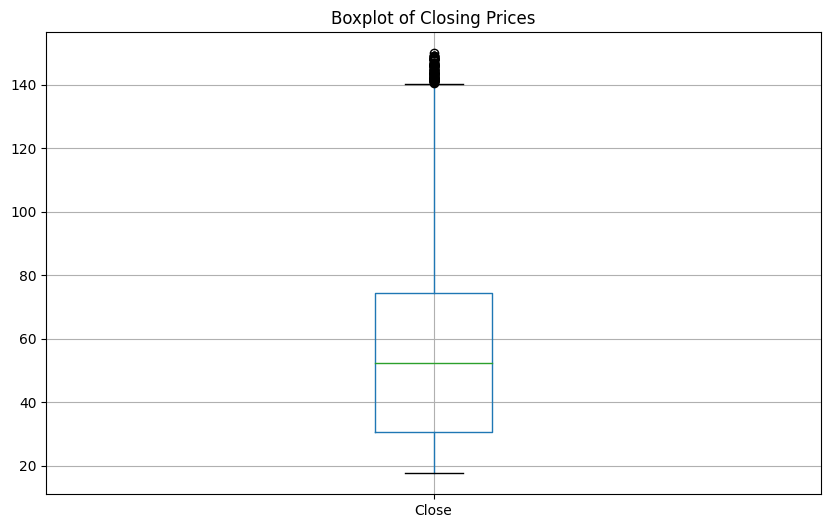

In [ ]:
# Box plot of closing prices
plt.figure(figsize=(10, 6))
stock_data.boxplot(column='Close')
plt.title('Boxplot of Closing Prices')
plt.show()

<Figure size 1400x700 with 0 Axes>

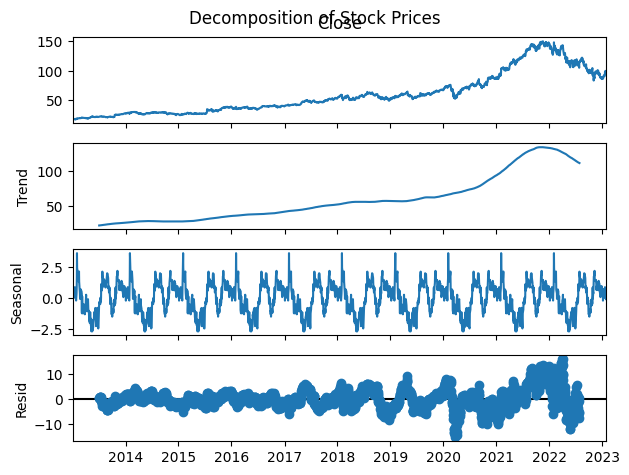

In [ ]:
from statistics import mode
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series into trend, seasonality, and residuals
result = seasonal_decompose(stock_data['Close'], model='additive', period=252)  # Assuming 252 trading days in a year

# Plot the decomposed components
plt.figure(figsize=(14, 7))
result.plot()
plt.suptitle('Decomposition of Stock Prices')
plt.show()

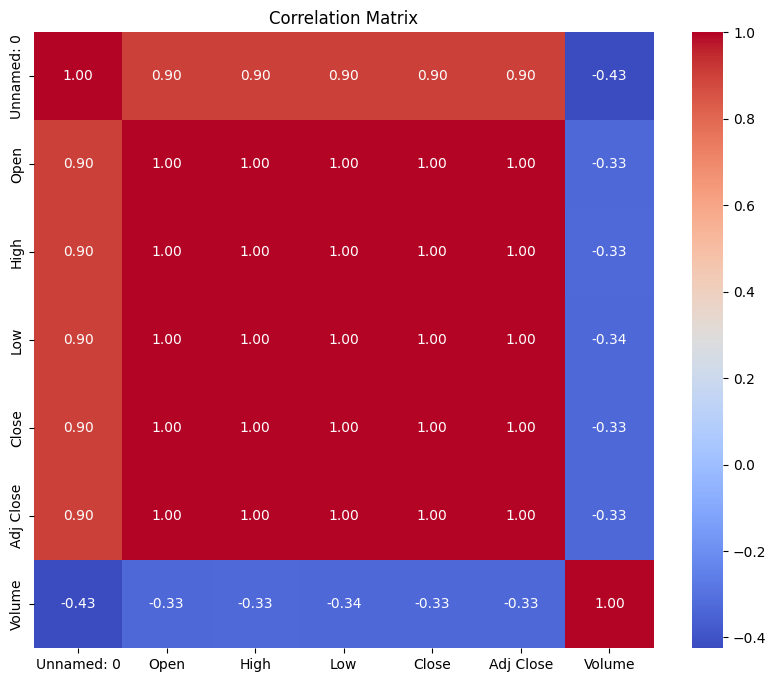

In [ ]:
# Calculate and visualize correlation matrix
correlation_matrix = stock_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

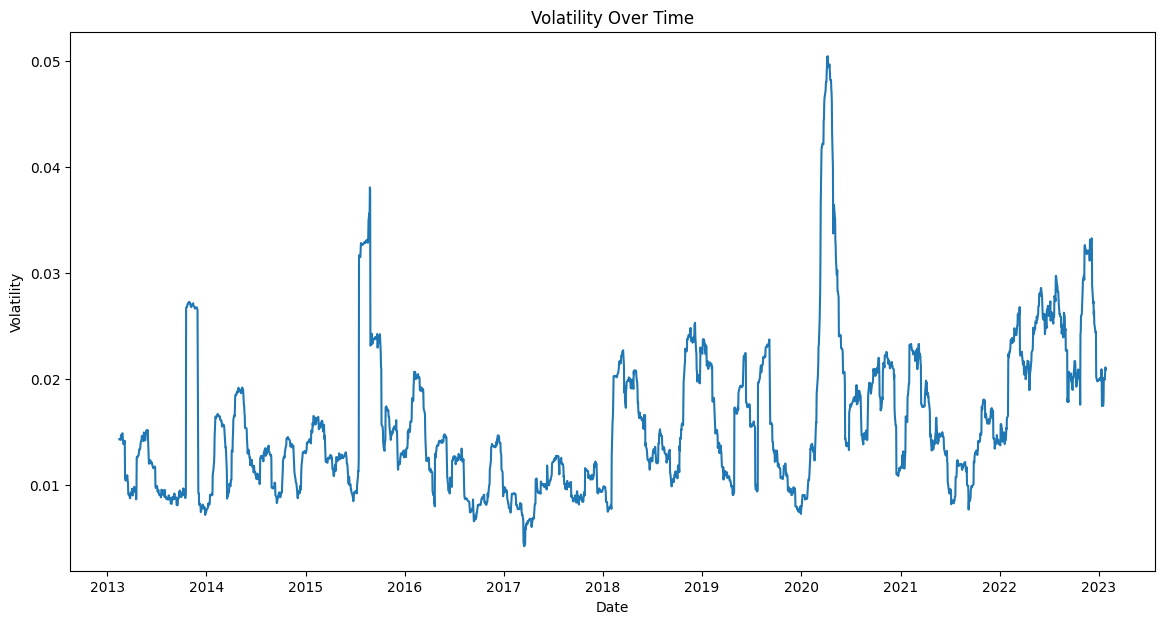

In [ ]:
# Calculate daily returns
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Plot volatility over time
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Daily_Return'].rolling(window=30).std())  # 30-day rolling standard deviation
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

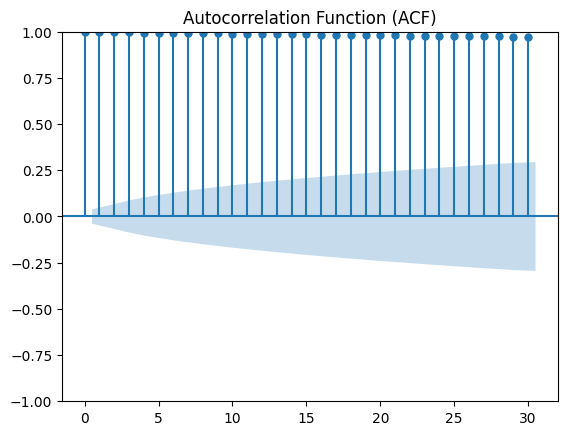

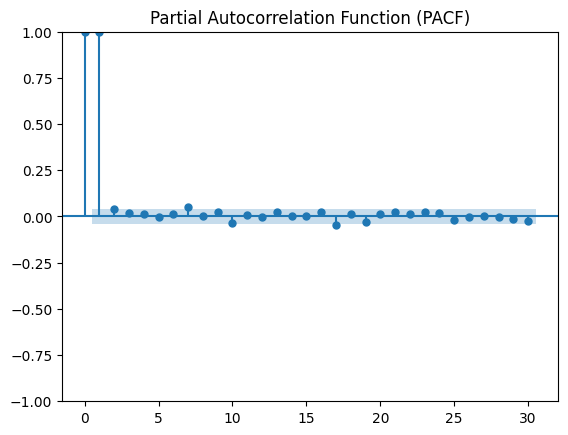

ADF Statistic: -0.7762975945564797
p-value: 0.8259855226880644
Critical Values: {'1%': -3.432955889694659, '5%': -2.8626912706428715, '10%': -2.567382865538409}
Fail to reject the null hypothesis; the time series is non-stationary.
{ValueError('Timeseries contains inf or nans')}
ADF Statistic: -11.648022572869397
p-value: 2.069516808437459e-21
Critical Values: {'1%': -3.432955889694659, '5%': -2.8626912706428715, '10%': -2.567382865538409}
Reject the null hypothesis; the time series is stationary.


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Autocorrelation and Partial Autocorrelation
plot_acf(stock_data['Close'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(stock_data['Close'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Stationarity Test
def test_stationarity(timeseries):
    # Check for NaN or infinite values in the timeseries
    try:
        if not np.isfinite(timeseries).all():
            raise ValueError('Timeseries contains inf or nans')
    except ValueError as e:
        print({e})
    # Perform Dickey-Fuller test
    timeseries=timeseries[np.isfinite(timeseries)]
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Reject the null hypothesis; the time series is stationary.")
    else:
        print("Fail to reject the null hypothesis; the time series is non-stationary.")
test_stationarity(stock_data['Close'])

# Differencing (if needed)
# When differencing, immediately drop the NaN values that result.
stock_data['Close_diff'] = stock_data['Close'].diff().dropna()

# Explicitly drop any rows with NaN or infinite values before passing to the function
stock_data['Close_diff'].replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data['Close_diff'].dropna(inplace=True)

# Now we can safely test stationarity
test_stationarity(stock_data['Close_diff'])

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00


In [ ]:
#Train/Test split and identify optimal model
from pmdarima import auto_arima
import math

#Train with 90%, test with 10%
#Training data is first 90%, test is remaining 10%
train_size = math.floor(stock_data.shape[0] * 0.90)
test_size = stock_data.shape[0] - train_size

#Split endogenous target data and exogenous features for non-stationary series
train_data_ns = stock_data.iloc[:train_size]['Close'].to_numpy()
train_exog = stock_data.iloc[:train_size].drop(['Unnamed: 0','Close',
                                                'Close_diff','Daily_Return'], axis=1).to_numpy()
test_data_ns = stock_data.iloc[train_size:]['Close'].to_numpy()
test_exog = stock_data.iloc[train_size:].drop(['Unnamed: 0','Close',
                                               'Close_diff','Daily_Return'], axis=1).to_numpy()
#Auto arima to identify best model for non-stationary series
model1 = auto_arima(train_data_ns, m=12, seasonal=True)
model1.summary()

KeyboardInterrupt: ignored

In [ ]:
#Split endogenous target data and exogenous features for stationary series
train_data = stock_data.iloc[:train_size]['Close_diff'].to_numpy()
train_exog = stock_data.iloc[:train_size].drop(['Unnamed: 0','Close',
                                                'Close_diff','Daily_Return'], axis=1).to_numpy()
test_data = stock_data.iloc[train_size:]['Close_diff'].to_numpy()
test_exog = stock_data.iloc[train_size:].drop(['Unnamed: 0','Close',
                                               'Close_diff','Daily_Return'], axis=1).to_numpy()
#Auto arima to identify best model for stationary series
model2 = auto_arima(train_data, m=12, seasonal=True)
model2.summary()

ValueError: ignored

In [ ]:
#Model1 training
exo_model1 = SARIMAX(train_data_ns,exog=train_exog, order=(1, 1, 0),
                seasonal_order=(1,0,1,12))
endo_model1 = SARIMAX(train_data, order=(1, 0, 0))
exo_results1 = exo_model1.fit()
endo_results1 = endo_model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE with exogenous variables: 2.9723754412618342e-18
MSE without exogenous variables: 12756.857481997078


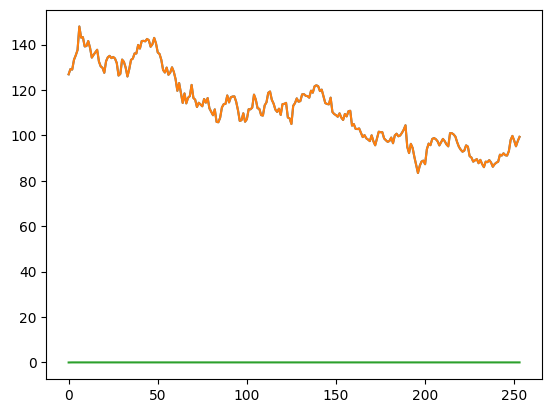

In [ ]:
#Model1 Evaluation
from sklearn.metrics import mean_squared_error
exo_pred1 = exo_results1.get_forecast(steps=test_size, exog=test_exog).predicted_mean
endo_pred1 = endo_results1.get_forecast(steps=test_size).predicted_mean
plt.plot(test_data_ns)
plt.plot(exo_pred1)
plt.plot(endo_pred1)
exo_mse1 = mean_squared_error(exo_pred1, test_data_ns)
print("MSE with exogenous variables:", exo_mse1)
endo_mse1 = mean_squared_error(endo_pred1, test_data_ns)
print("MSE without exogenous variables:", endo_mse1)

In [ ]:
#Model2 training
exo_model2 = SARIMAX(train_data,exog=train_exog, order=(1, 1, 0),
                seasonal_order=(1,0,1,12))
endo_model2 = SARIMAX(train_data, order=(1, 0, 0))
exo_results2 = exo_model2.fit()
endo_results2 = endo_model2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE with exogenous variables: 294.79335836773777
MSE without exogenous variables: 7.546339351295663


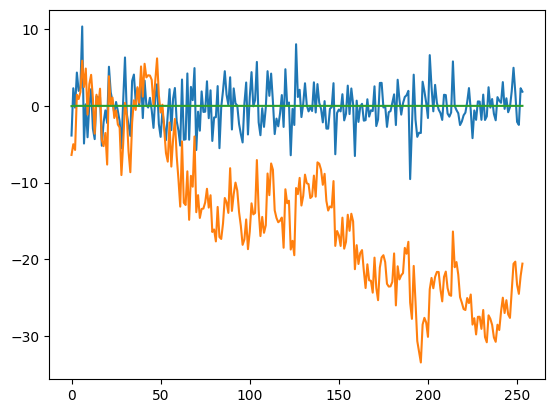

In [ ]:
#Model2 Evaluation
from sklearn.metrics import mean_squared_error
exo_pred2 = exo_results2.get_forecast(steps=test_size, exog=test_exog).predicted_mean
endo_pred2 = endo_results2.get_forecast(steps=test_size).predicted_mean
plt.plot(test_data)
plt.plot(exo_pred2)
plt.plot(endo_pred2)
exo_mse2 = mean_squared_error(exo_pred2, test_data)
print("MSE with exogenous variables:", exo_mse2)
endo_mse2 = mean_squared_error(endo_pred2, test_data)
print("MSE without exogenous variables:", endo_mse2)

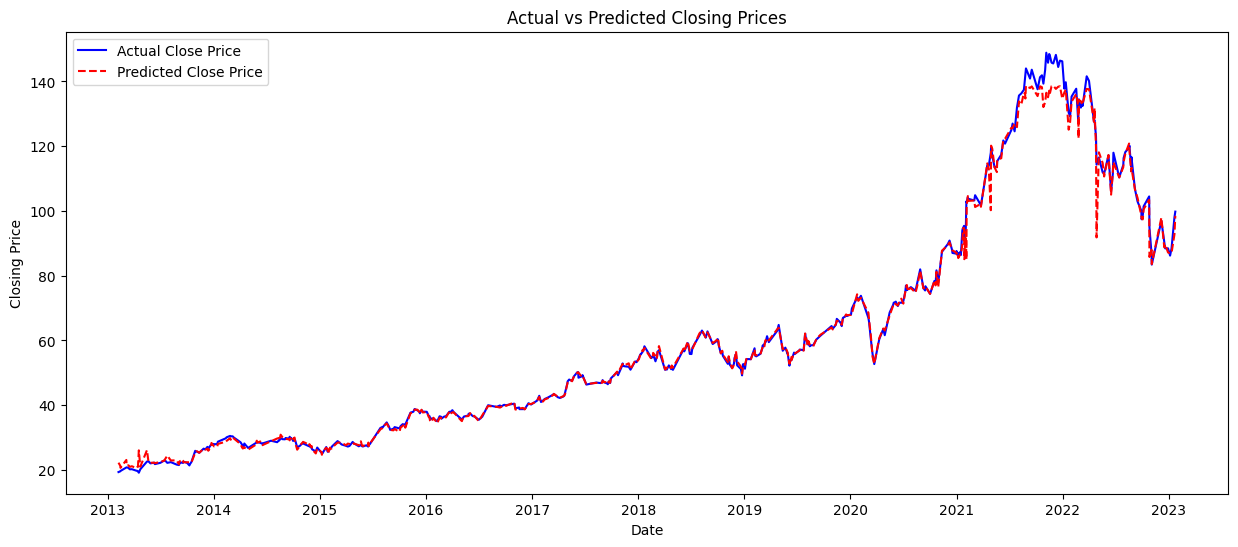

Mean Squared Error: 6.271104959604591
Mean Absolute Error: 1.0534896915313336
Root Mean Squared Error: 2.5042174345700476
R-squared: 0.9948277521559657


In [ ]:
#model3 training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preparing the dataset for SVM model
features = stock_data[['Open', 'High', 'Low', 'Volume']]
target = stock_data['Close']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and training the SVM model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# Predicting and evaluating the model
predictions = svm_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

# Create a DataFrame for visualization
comparison_df = pd.DataFrame({'Actual Close': y_test, 'Predicted Close': predictions})
comparison_df = comparison_df.sort_index()  # Sorting by date if the index represents the date

# Plotting the actual vs predicted closing prices
plt.figure(figsize=(15, 6))
plt.plot(comparison_df['Actual Close'], label='Actual Close Price', color='blue')
plt.plot(comparison_df['Predicted Close'], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

from sklearn.metrics import r2_score

# Calculate R-squared for the SVM model
r_squared = r2_score(y_test, predictions)
print(f'R-squared: {r_squared}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#model4 training and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Creating and training the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predicting and evaluating the Random Forest model
rf_predictions = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)

# Create a DataFrame for visualization
comparison_df = pd.DataFrame({'Actual Close': y_test, 'Predicted Close': rf_predictions})
comparison_df = comparison_df.sort_index()  # Sorting by date if the index represents the date

# Plotting the actual vs predicted closing prices
plt.figure(figsize=(15, 6))
plt.plot(comparison_df['Actual Close'], label='Actual Close Price', color='blue')
plt.plot(comparison_df['Predicted Close'], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Calculate R-squared for the SVM model
r_squared = r2_score(y_test, rf_predictions)
print(f'R-squared: {r_squared}')
print(f'Random Forest - Mean Squared Error: {rf_mse}')
print(f'Random Forest - Mean Absolute Error: {rf_mae}')
print(f'Random Forest - Root Mean Squared Error: {rf_rmse}')
